# OpenOptimizers - exercises

Author: Dr. Francesco Calcagno

Date: September 2025

Reference: github.com/francesco-calcagno/OpenOptimizers

## Requirements

Download required python libraries. These are extra to OpenOptimizers' requirements.

In [1]:
! pip install matplotlib  #required for plotting
! pip install rdkit       #required for MM energy minimization

## Utilities

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

# plotting settings
plt.rcParams["figure.dpi"] = 300
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Helvetica"]
plt.rcParams["lines.markersize"] = 4
plt.rcParams["font.size"] = 12
plt.rcParams["figure.constrained_layout.use"] = True
xformatter = FuncFormatter(lambda x, _: f"{x:.1f}")
yformatter = FuncFormatter(lambda x, _: f"{x:.1f}")


def plot_1D(x, y, bounds, func, label=r'$y=f(x)$', label2='optimizer'):
    xx = np.arange(bounds[0], bounds[1], (bounds[1]-bounds[0])/1000)
    plt.plot(xx, [func([i]) for i in xx], color='black', label=label)
    plt.plot(x, y, color='crimson', linestyle='--', label=label2)
    plt.ylim(-0.1, 0.45)
    plt.scatter(x, y, color='crimson')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.legend(loc='upper center')
    plt.show()
    


def plot_2D(x, bounds, func):
    x0 = [i[0] for i in x]
    x1 = [i[1] for i in x]
    X, Y = np.meshgrid(np.linspace(bounds[0], bounds[1], 20000), np.linspace(bounds[0], bounds[1], 200))
    Z = func([X, Y])

    contour = plt.contourf(X, Y, Z, levels=50, cmap='jet') 
    plt.colorbar(contour, label=r'$f(x_0, x_1)$') 
    plt.plot(x0, x1, color='black', linestyle='--')
    plt.xlabel(r'$x_0$')
    plt.ylabel(r'$x_1$')
    


Set-up imports for all OpenOptimizers methods

In [3]:
from src.PS import PS as ps
from src.GD import GD as gd
from src.Adam import Adam as adam

## Exercise 1

Molecular Mechanics (MM) describes interactions between atoms according to classical physics. Namely, it describes atoms as classical (charged) balls, while bonds as springs. 

In MM, the energy of chemical systems is expressed in terms of a force field (FF), which is a set of parameterized functions describing the potential energy in function of the Cartesian position of atoms.

Among different FF's terms, the bond strength is defined according to the Hook law. The energy $E$ of a bond between two atoms at a distance $x$ is 

$$
E(x) = \frac{1}{2} k (x-x_0)^2,
$$

where x_0 is the equilibrium distance.

In the following, we implement a Python function for the Hook law and optimize the distance $x$ with OpenOptimizers.

In [4]:
def hook_law(
    x,
    x0=0.8,
    k=2,
    ):
    
    '''
    Hook law
    
    Args:
        x (float): current distance.
        x0 (float): equilibrium value.

    Returns:
        E (float): energy value
    '''

    displacement = (x[0]-x0)**2
    E = 0.5*k*displacement
    
    return E


In [5]:
# Optimizers settings

parameters = [1.3] # <--- we start optimizing from this x value
bounds = (.2, 1.4) # <--- ditance between atoms cannot be negative!

maxiter = 10000
convergence_threashold = 0.0001

# PS
beta = 0.99

# GD
learning_rate = 0.01
eps = 1e-8

# Adam
beta1 = 0.9
beta2 = 0.999


### Pattern Search

In [6]:
opt = ps(
    parameters=parameters,
    bounds=bounds,
    maxiter=maxiter,
    random_samples=None,
    convergence_threashold=convergence_threashold,
    window_epochs=3,
    random_state=168548645,
    verbose=False,
    # PS's arguments
    beta=beta,
)


Minimum = 0.00000    Iterations = 2001


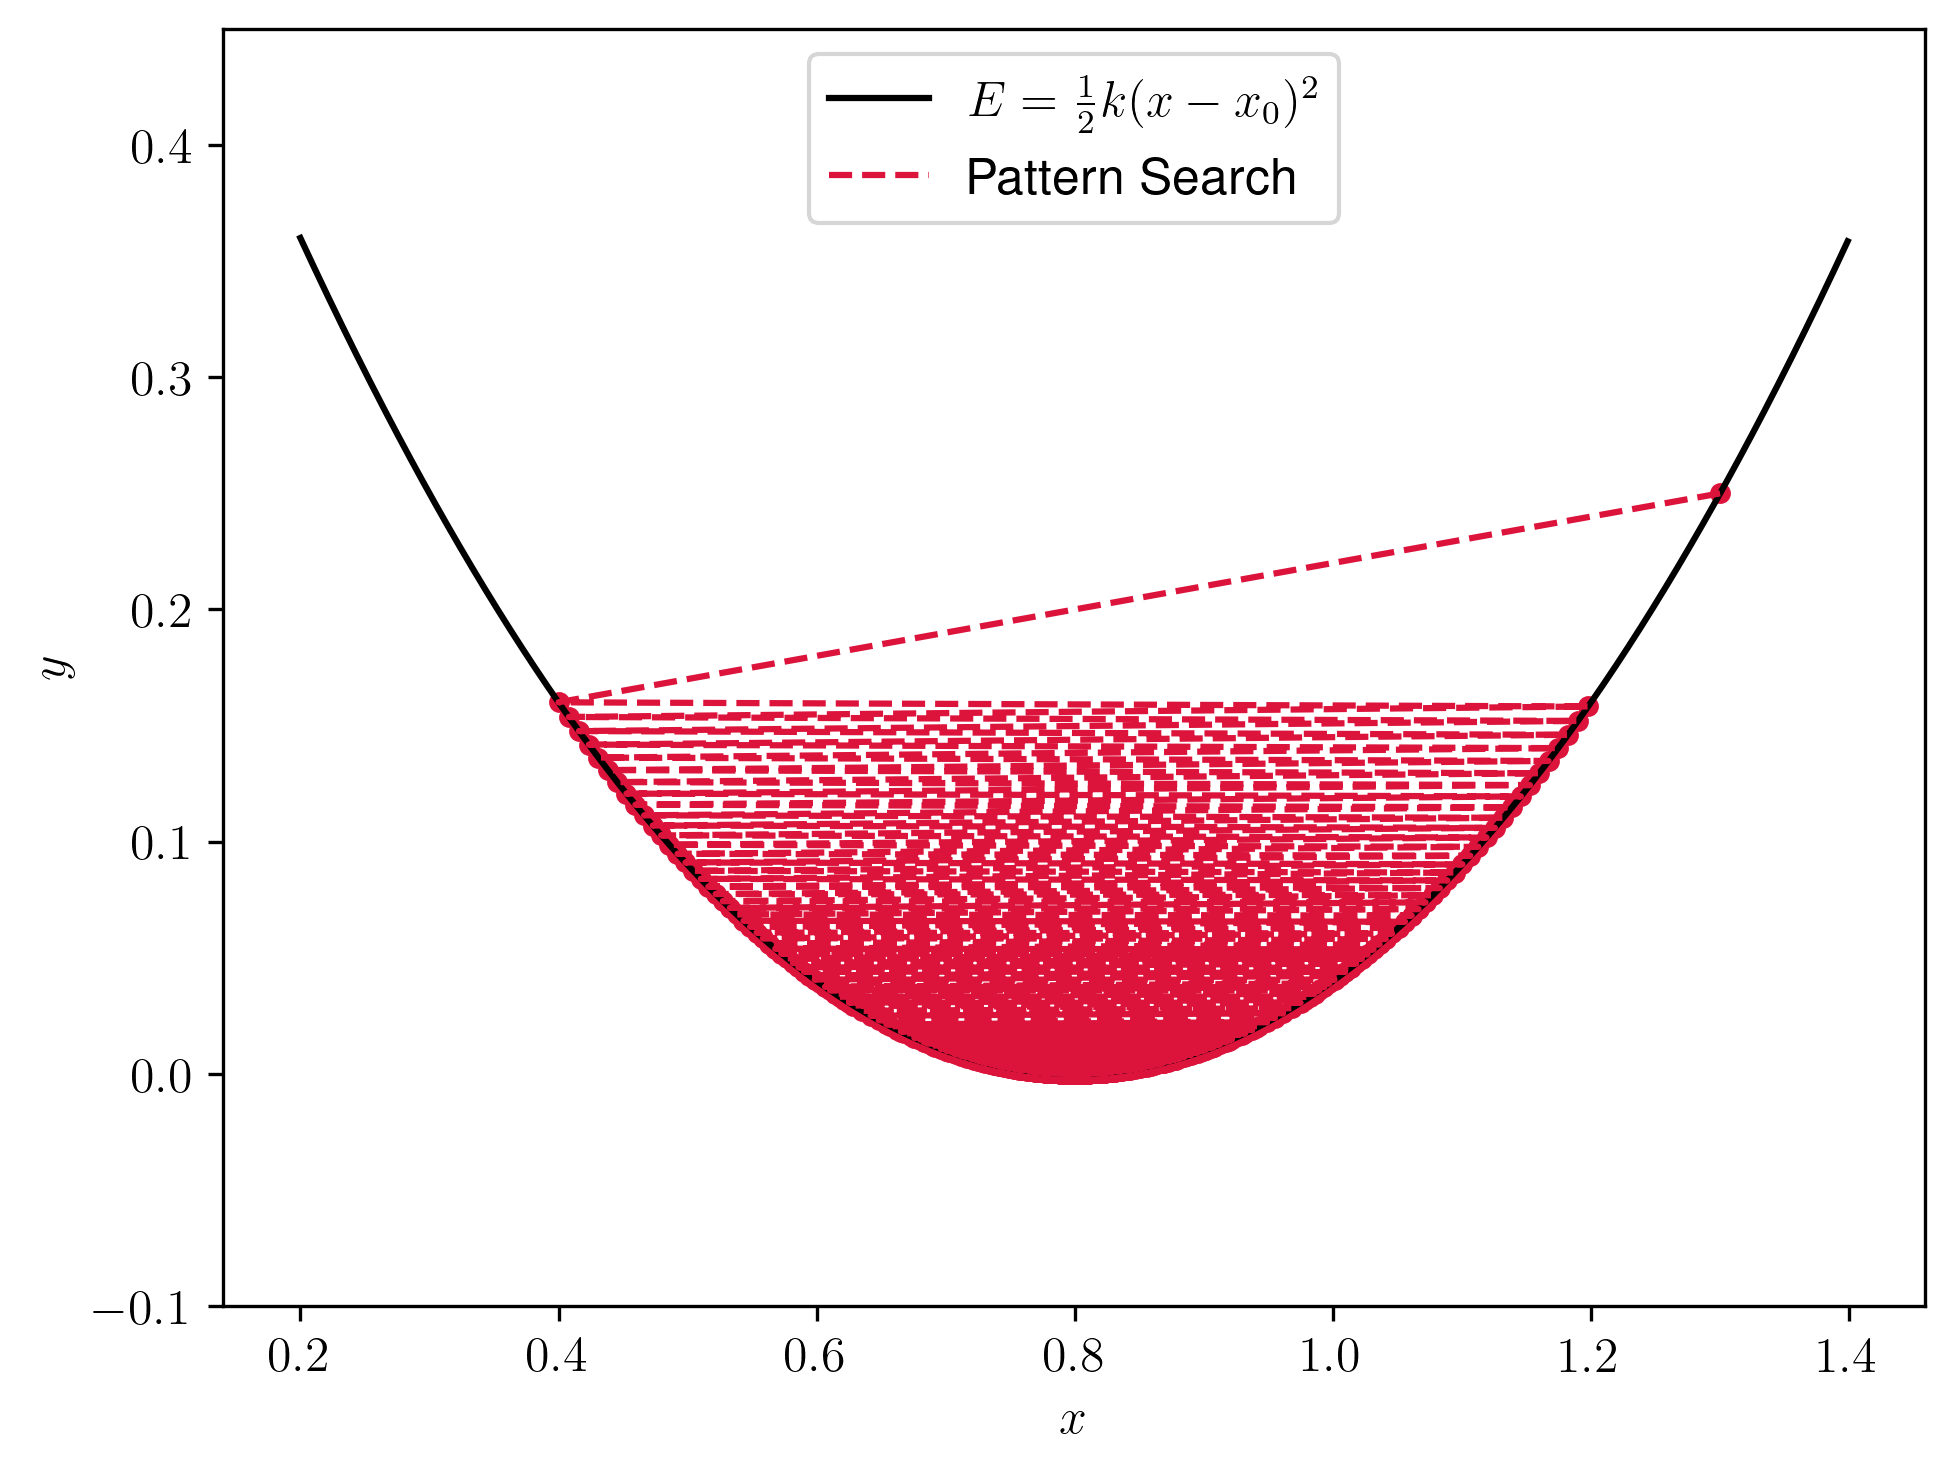

In [7]:
y_best, x_best, history = opt.minimize(hook_law)
print(f"Minimum = {y_best:<10.5f} Iterations = {opt.iteration}")

x, y = history["x"], history["y"]
plot_1D(x, y, bounds, hook_law, label=r'$E=\frac{1}{2}k(x-x_0)^2$', label2='Pattern Search')

### Gradient Descendent

In [8]:
opt = gd(
    parameters=parameters,
    bounds=bounds,
    maxiter=maxiter,
    random_samples=None,
    convergence_threashold=convergence_threashold,
    window_epochs=3,
    random_state=168548645,
    verbose=False,
    # GD's arguments
    learning_rate=learning_rate,
    eps=eps,
)


Minimum = 0.00000    Iterations = 2001


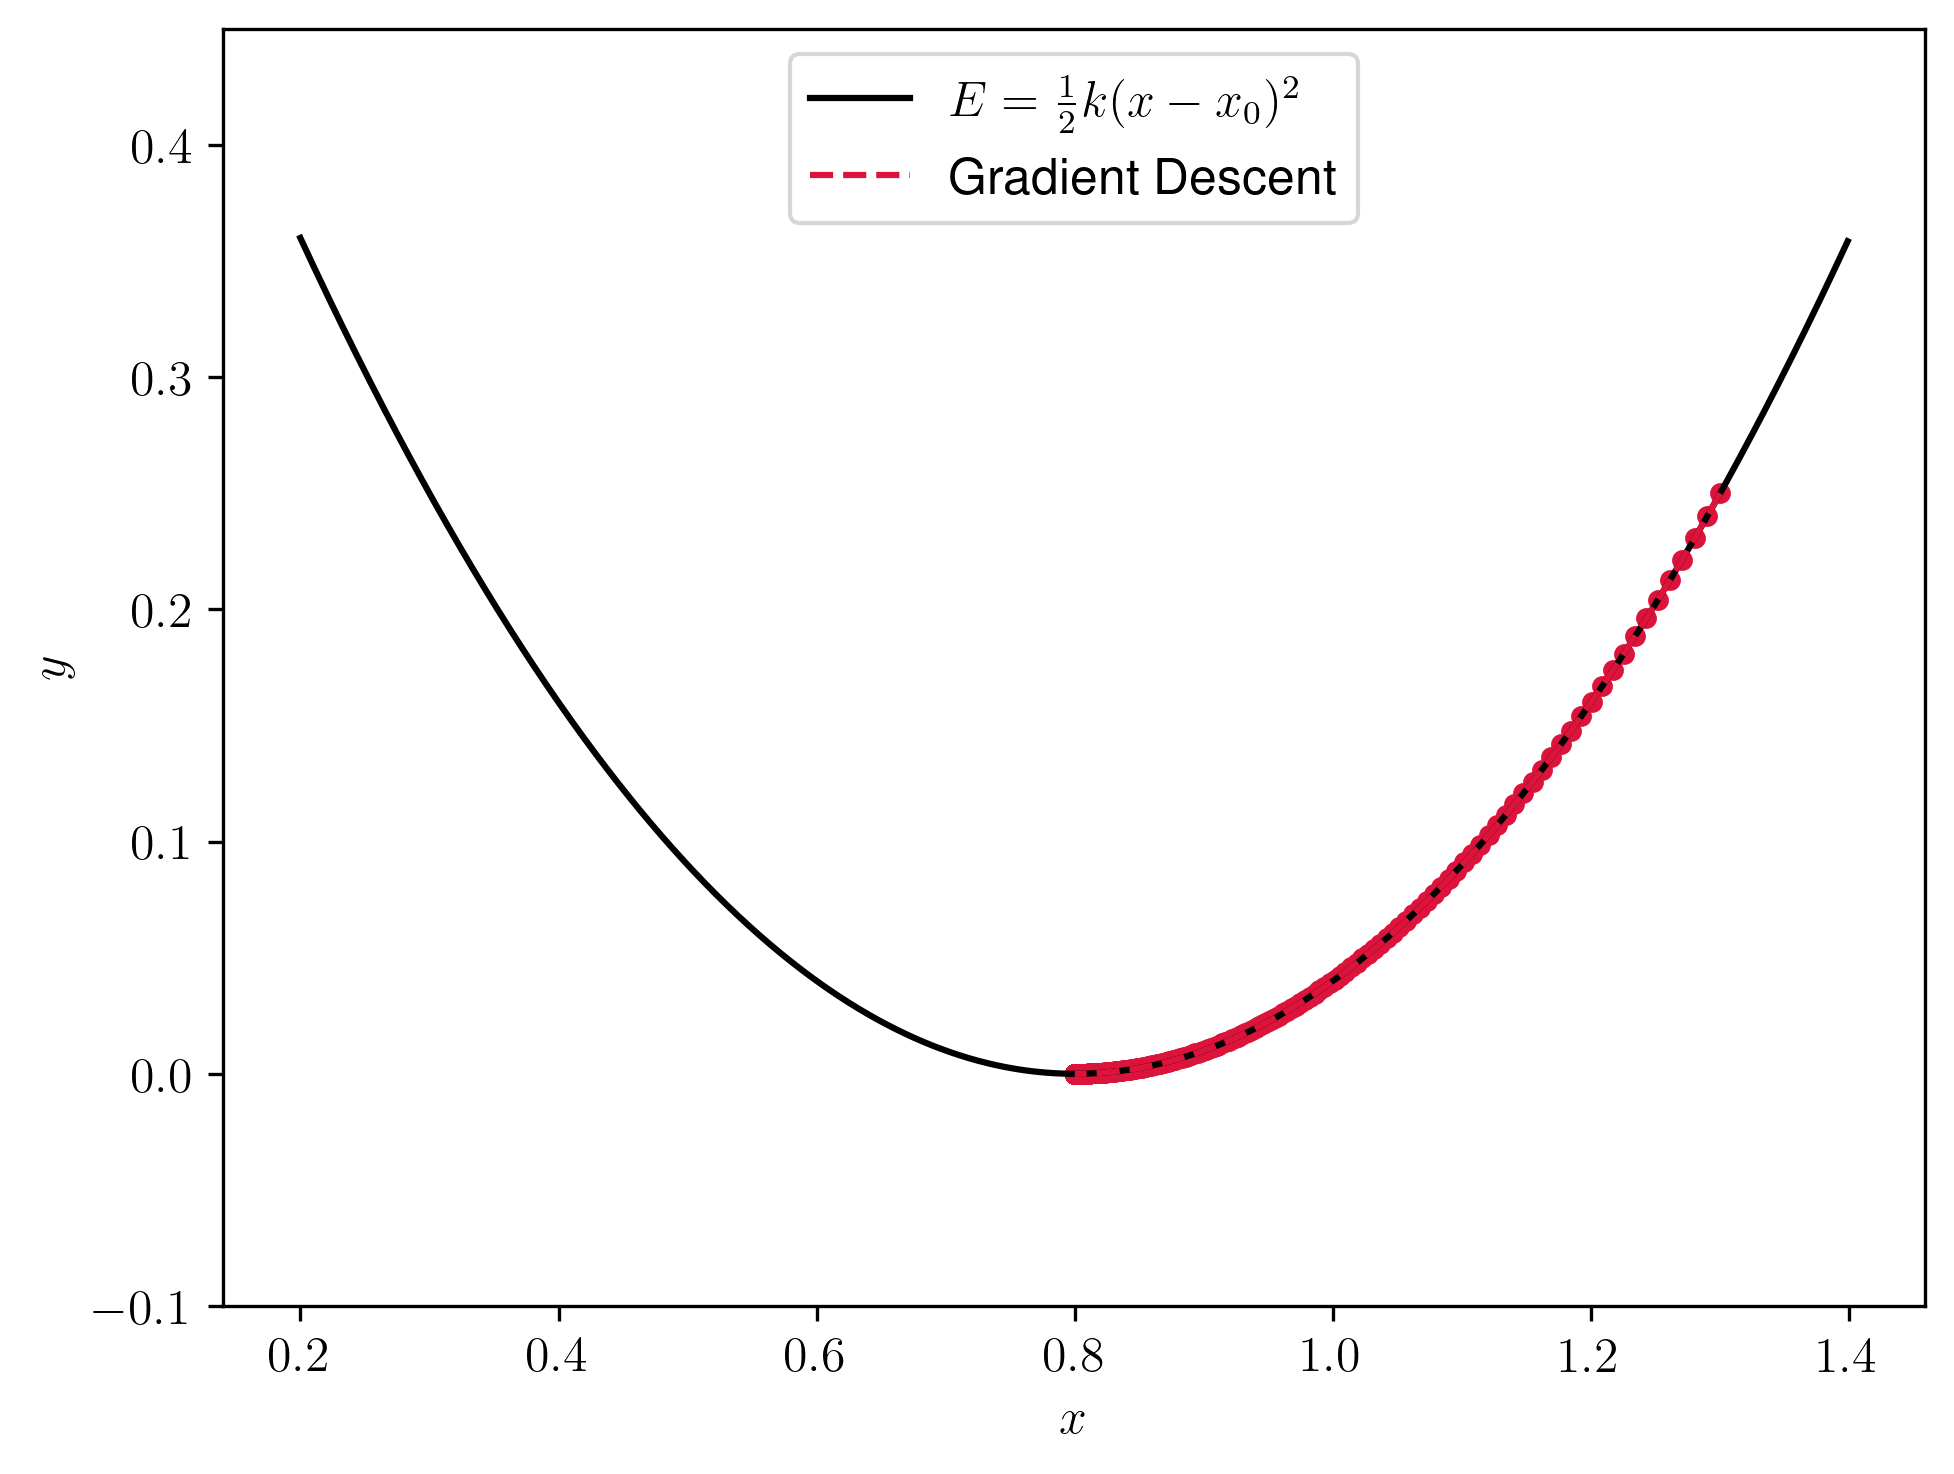

In [9]:
y_best, x_best, history = opt.minimize(hook_law)
print(f"Minimum = {y_best:<10.5f} Iterations = {opt.iteration}")

x, y = history["x"], history["y"]
plot_1D(x, y, bounds, hook_law, label=r'$E=\frac{1}{2}k(x-x_0)^2$', label2='Gradient Descent')

### Adam

In [10]:
opt = adam(
    parameters=parameters,
    bounds=bounds,
    maxiter=maxiter,
    random_samples=None,
    convergence_threashold=convergence_threashold,
    window_epochs=3,
    random_state=168548645,
    verbose=False,
    # Adam's arguments
    learning_rate=learning_rate,
    beta1 = beta1,
    beta2 = beta2,
)


Minimum = 0.00000    Iterations = 2001


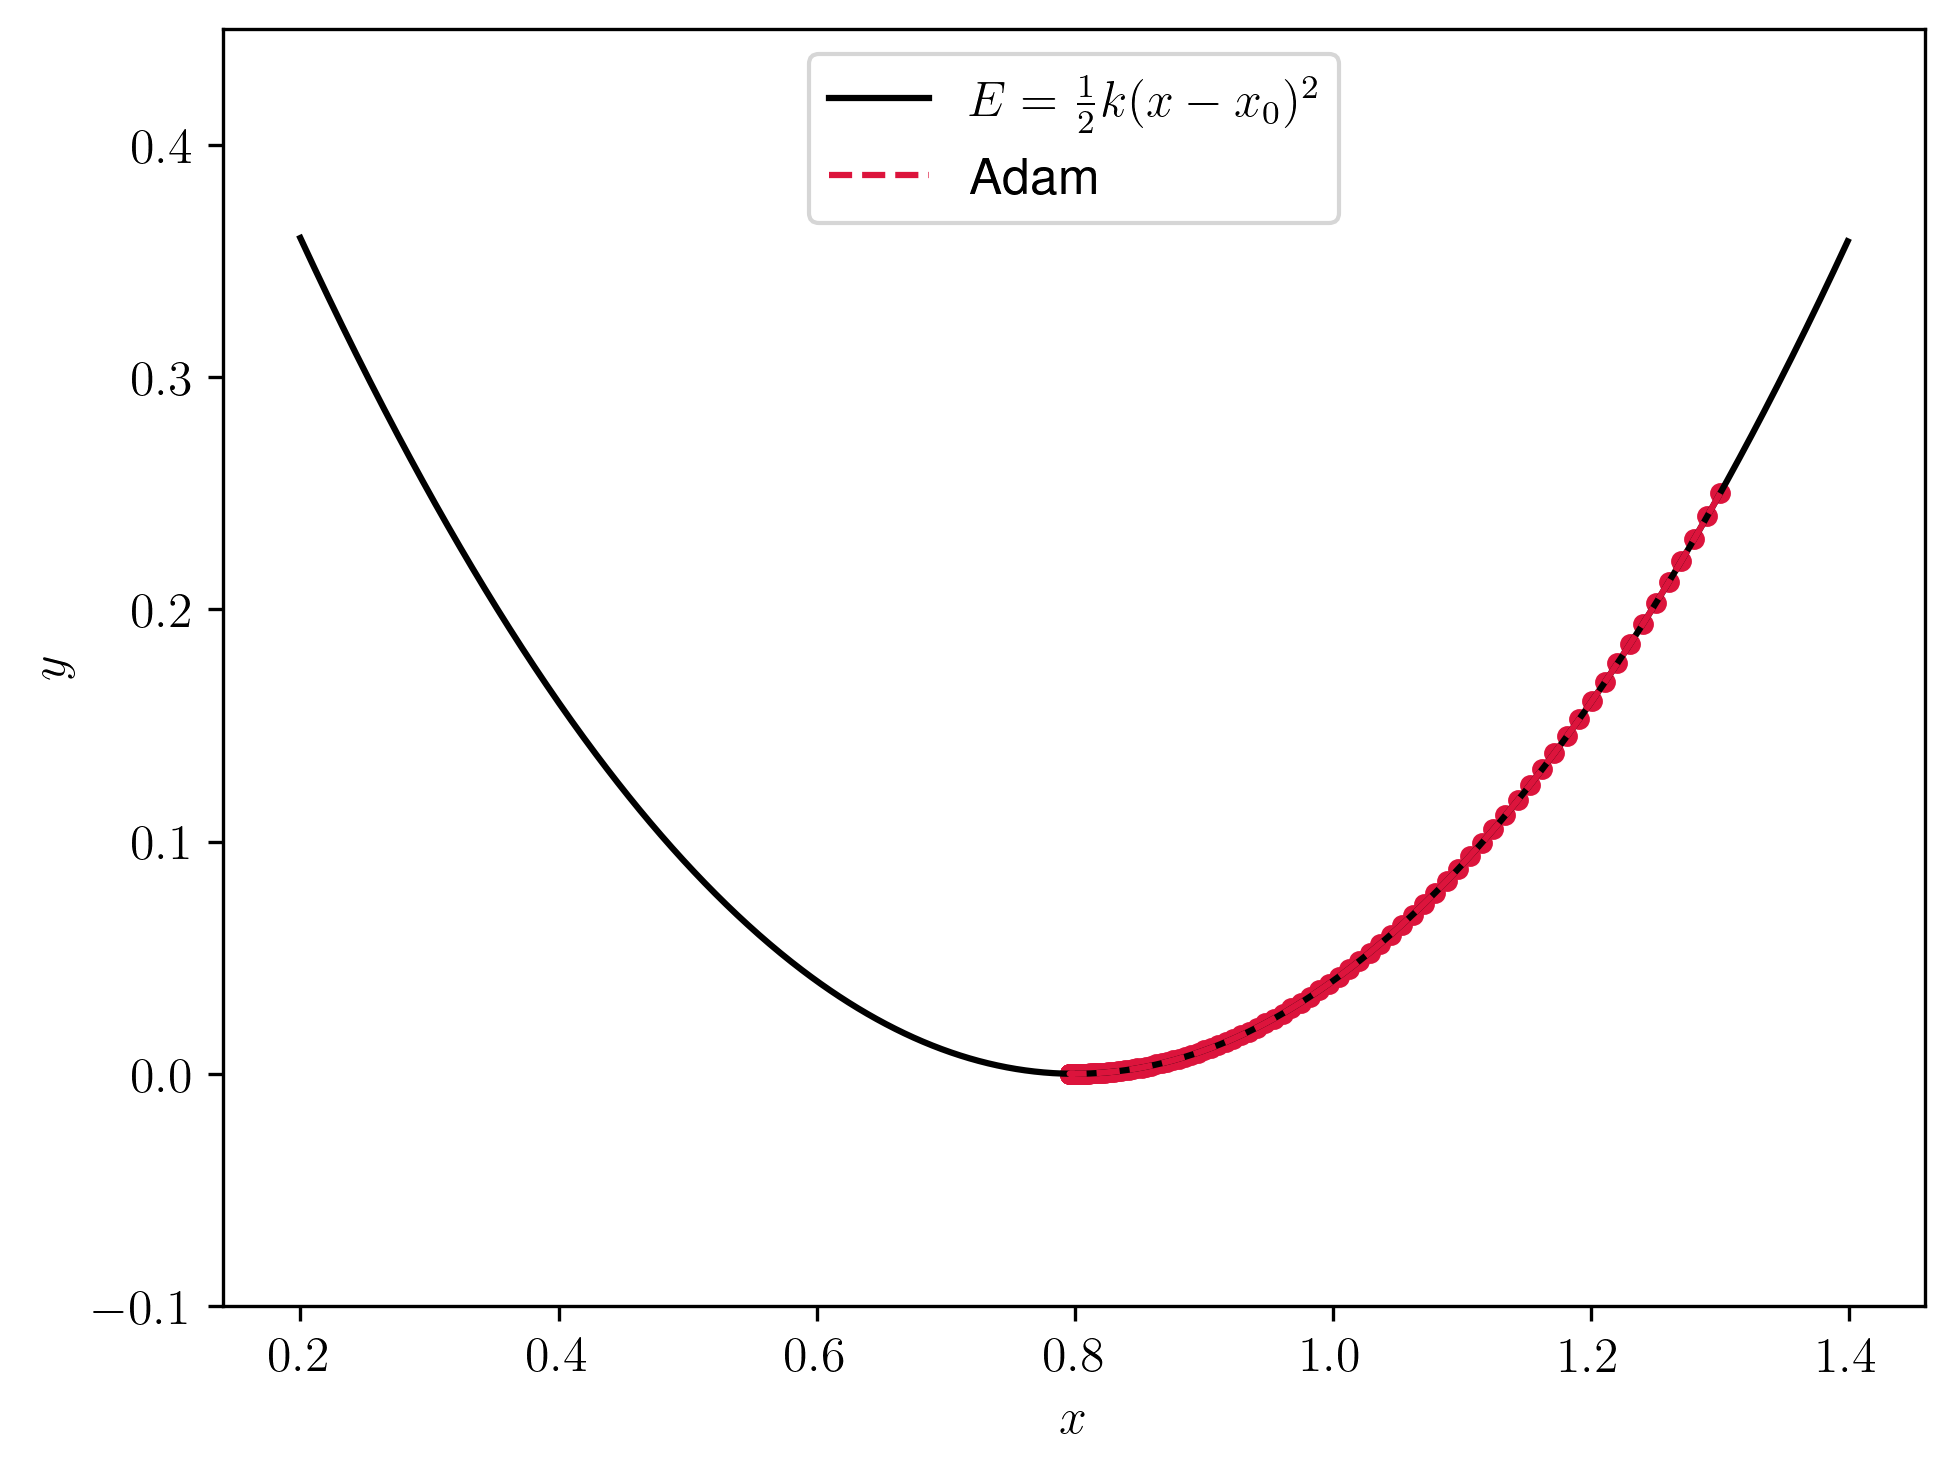

In [11]:
y_best, x_best, history = opt.minimize(hook_law)
print(f"Minimum = {y_best:<10.5f} Iterations = {opt.iteration}")

x, y = history["x"], history["y"]

plot_1D(x, y, bounds, hook_law, label=r'$E=\frac{1}{2}k(x-x_0)^2$', label2='Adam')

### Questions

- How do optimizers behave differently?
- Does PS outperform GD ar Adam?
- Compare the number of iterations for each algorithm.

## Exercise 2

Many optimization tasks are accomplished in noisy environments, e.g. in quantum computations, where optimizers have to deal with rugged surfaces. Here we include a random noise term to the Hook Law function defined above.

In [12]:
def noisy_hook_law(
    x,
    x0=0.8,
    k=2,
    ):
    
    '''
    Hook law
    
    Args:
        x (float): current distance.
        x0 (float): equilibrium value.

    Returns:
        E (float): ener-x0)
    E = (1/2) * k * displacement**2
    gy value.
    '''
    noise = np.random.uniform(-0.05, 0.05)
    displacement = (x[0]-x0)**2
    E = 0.5*k*displacement
    
    return E + noise

In [13]:
# Optimizers settings

maxiter = 5000
convergence_threashold=0.0001

learning_rate = 0.01
eps = 1e-8

beta = 0.99
beta1 = 0.9
beta2 = 0.999

seed = 23456789

### Adam

Minimum = 0.00363    Iterations = 1001


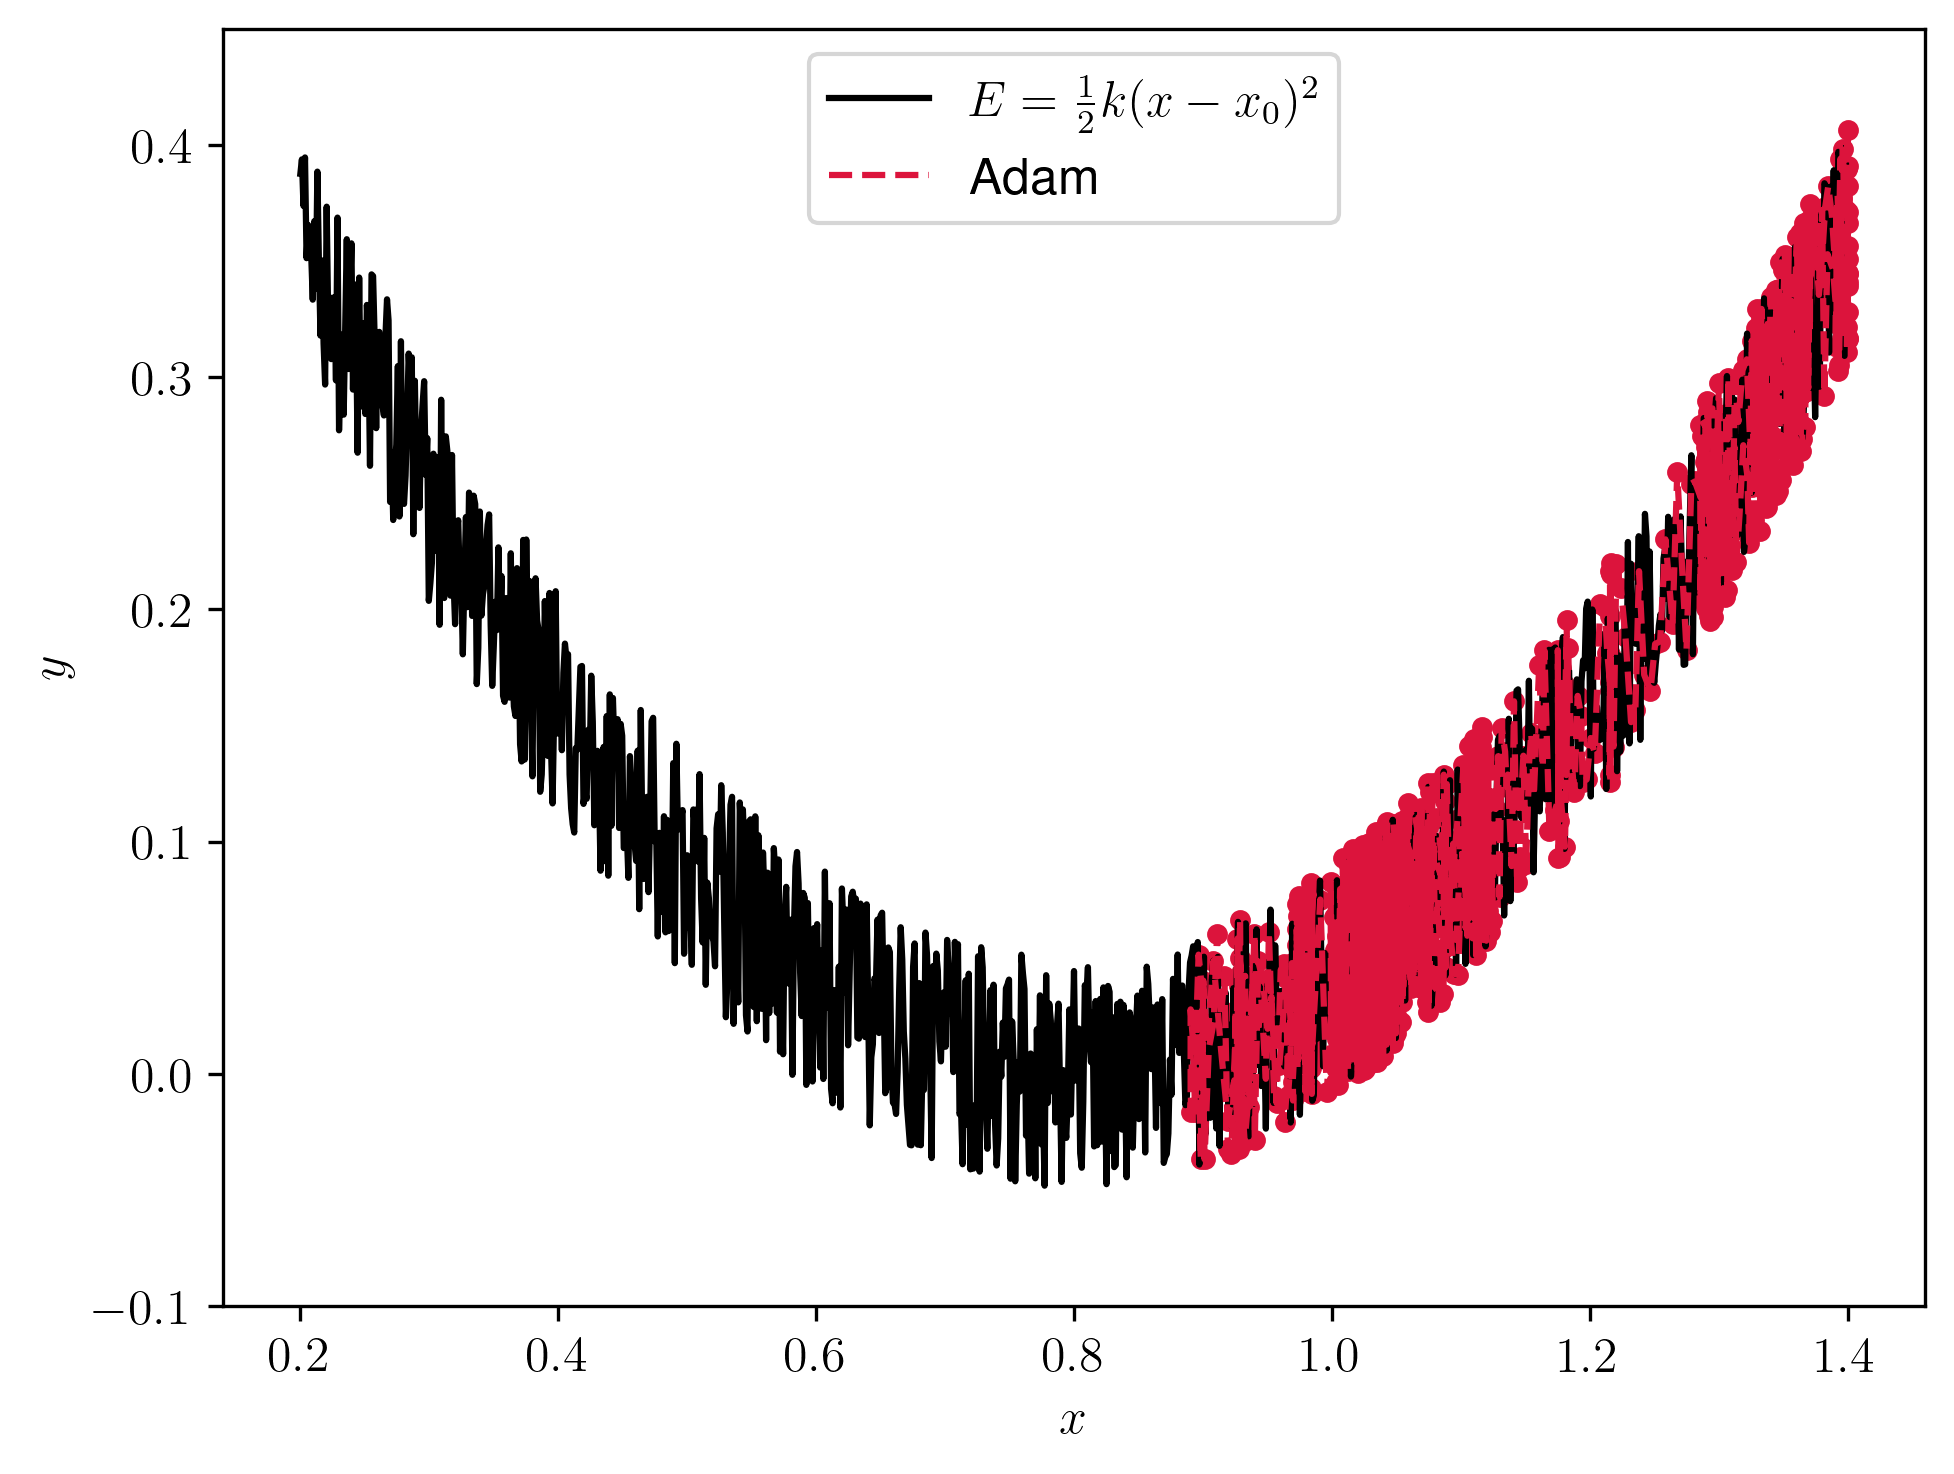

In [14]:
np.random.seed(seed)

opt = adam(
    parameters=parameters,
    bounds=bounds,
    maxiter=maxiter,
    random_samples=None,
    convergence_threashold=convergence_threashold,
    window_epochs=3,
    random_state=168548645,
    verbose=False,
    # Adam's arguments
    learning_rate=learning_rate,
    beta1 = beta1,
    beta2 = beta2,
)

y_best, x_best, history = opt.minimize(noisy_hook_law)
print(f"Minimum = {y_best:<10.5f} Iterations = {opt.iteration}")

x, y = history["x"], history["y"]
plot_1D(x, y, bounds, noisy_hook_law, label=r'$E=\frac{1}{2}k(x-x_0)^2$', label2='Adam')

### Gradient Descent

Minimum = 0.33827    Iterations = 1001


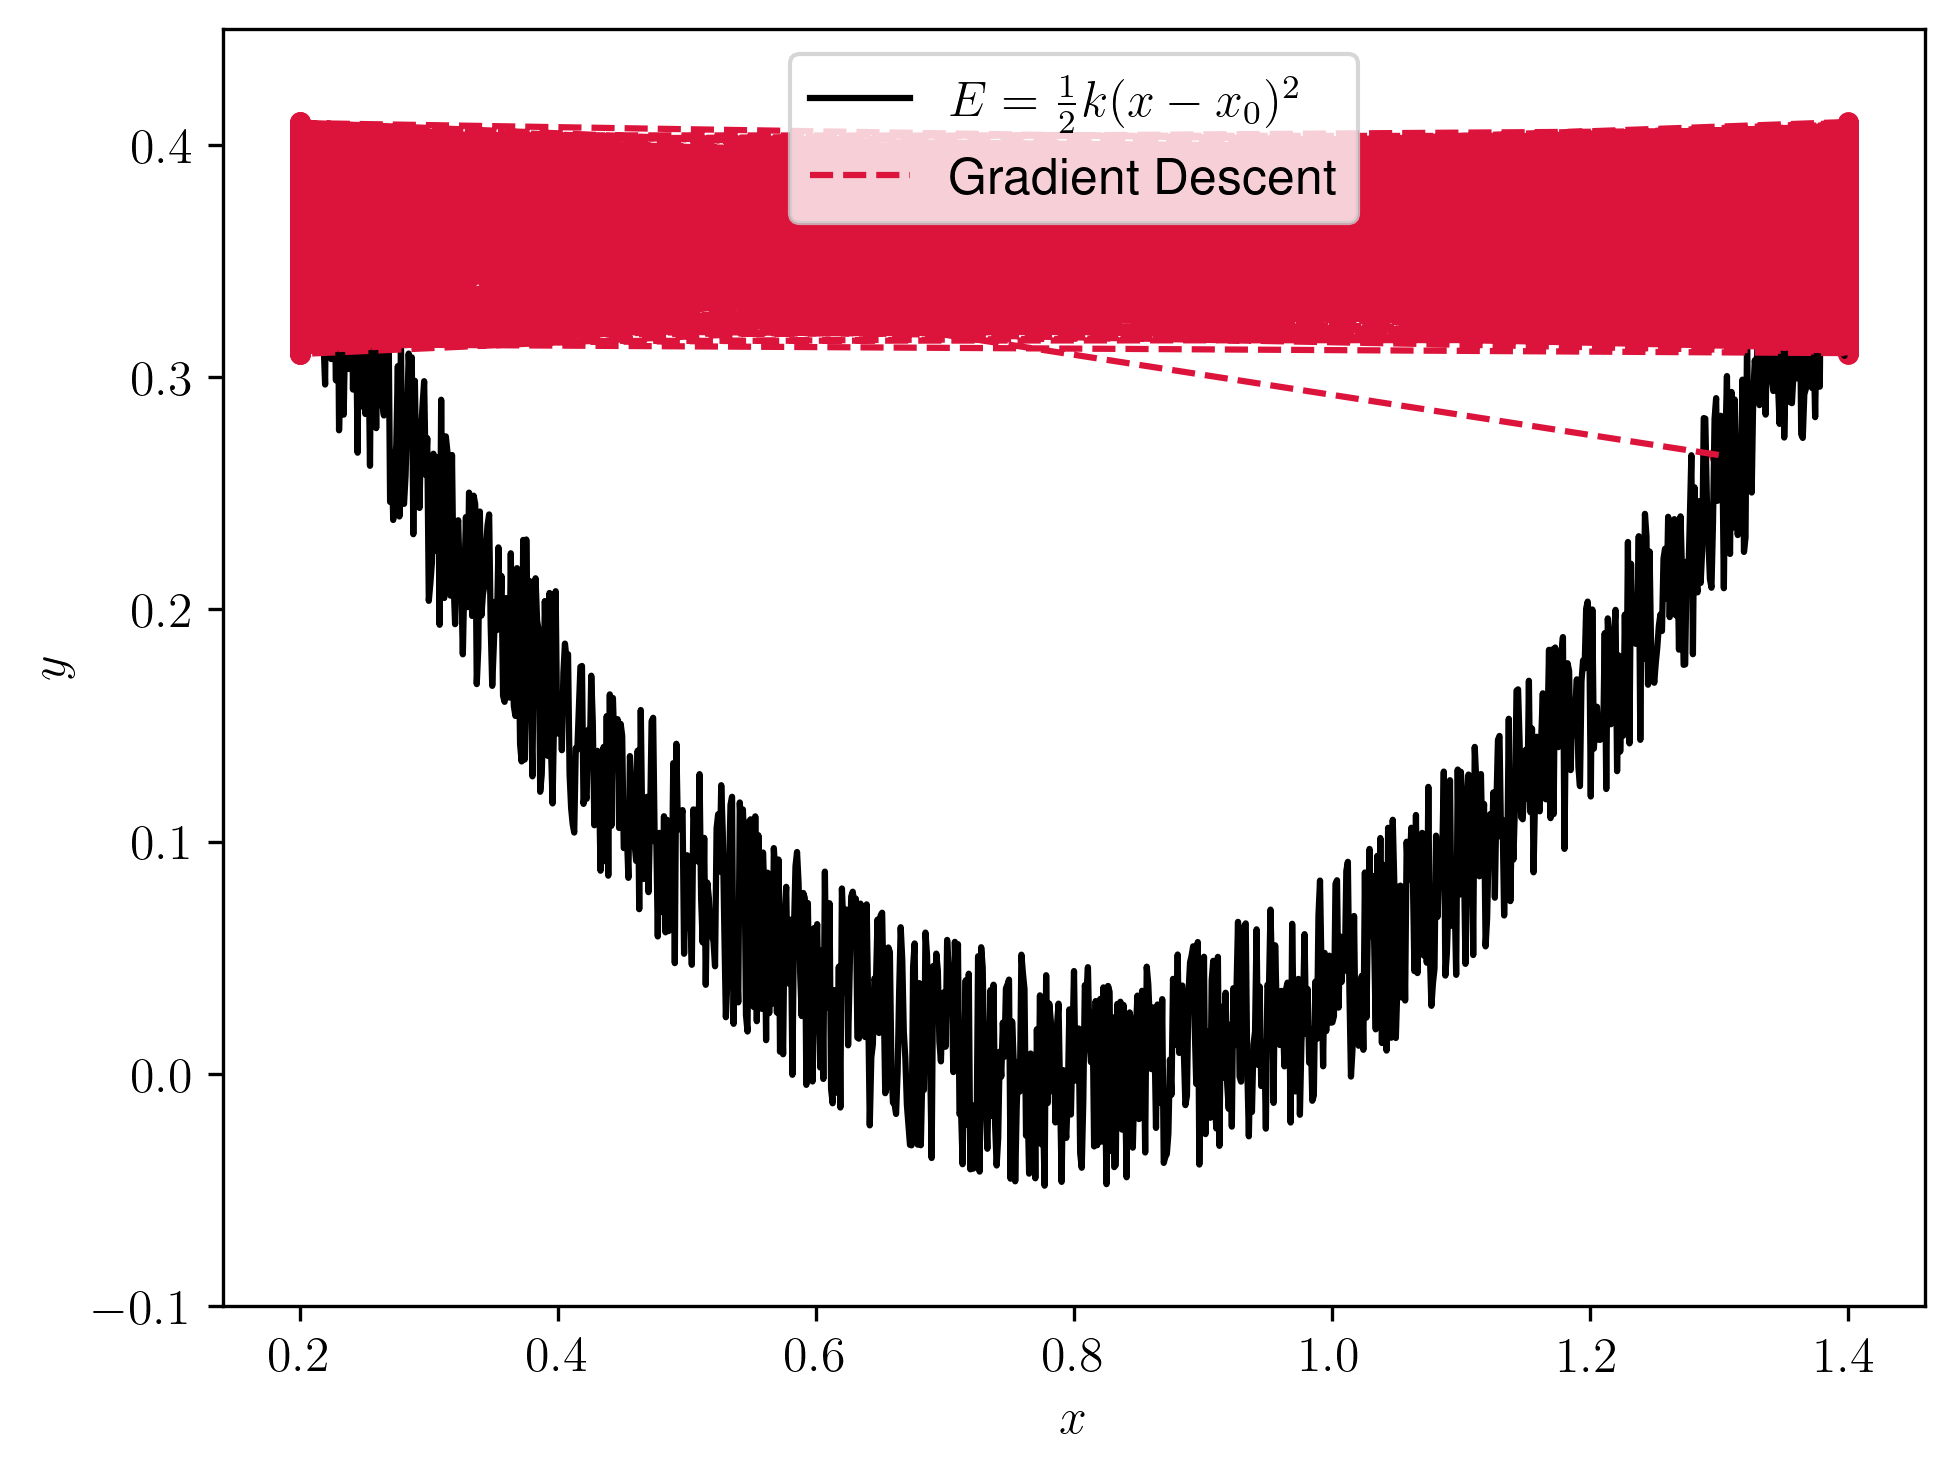

In [15]:
np.random.seed(seed)

opt = gd(
    parameters=parameters,
    bounds=bounds,
    maxiter=maxiter,
    random_samples=None,
    convergence_threashold=convergence_threashold,
    window_epochs=3,
    random_state=168548645,
    verbose=False,
    # GD's arguments
    learning_rate=learning_rate,
)

y_best, x_best, history = opt.minimize(noisy_hook_law)
print(f"Minimum = {y_best:<10.5f} Iterations = {opt.iteration}")

x, y = history["x"], history["y"]
plot_1D(x, y, bounds, noisy_hook_law, label=r'$E=\frac{1}{2}k(x-x_0)^2$', label2='Gradient Descent')

### Pattern Search

Minimum = -0.04987   Iterations = 1001


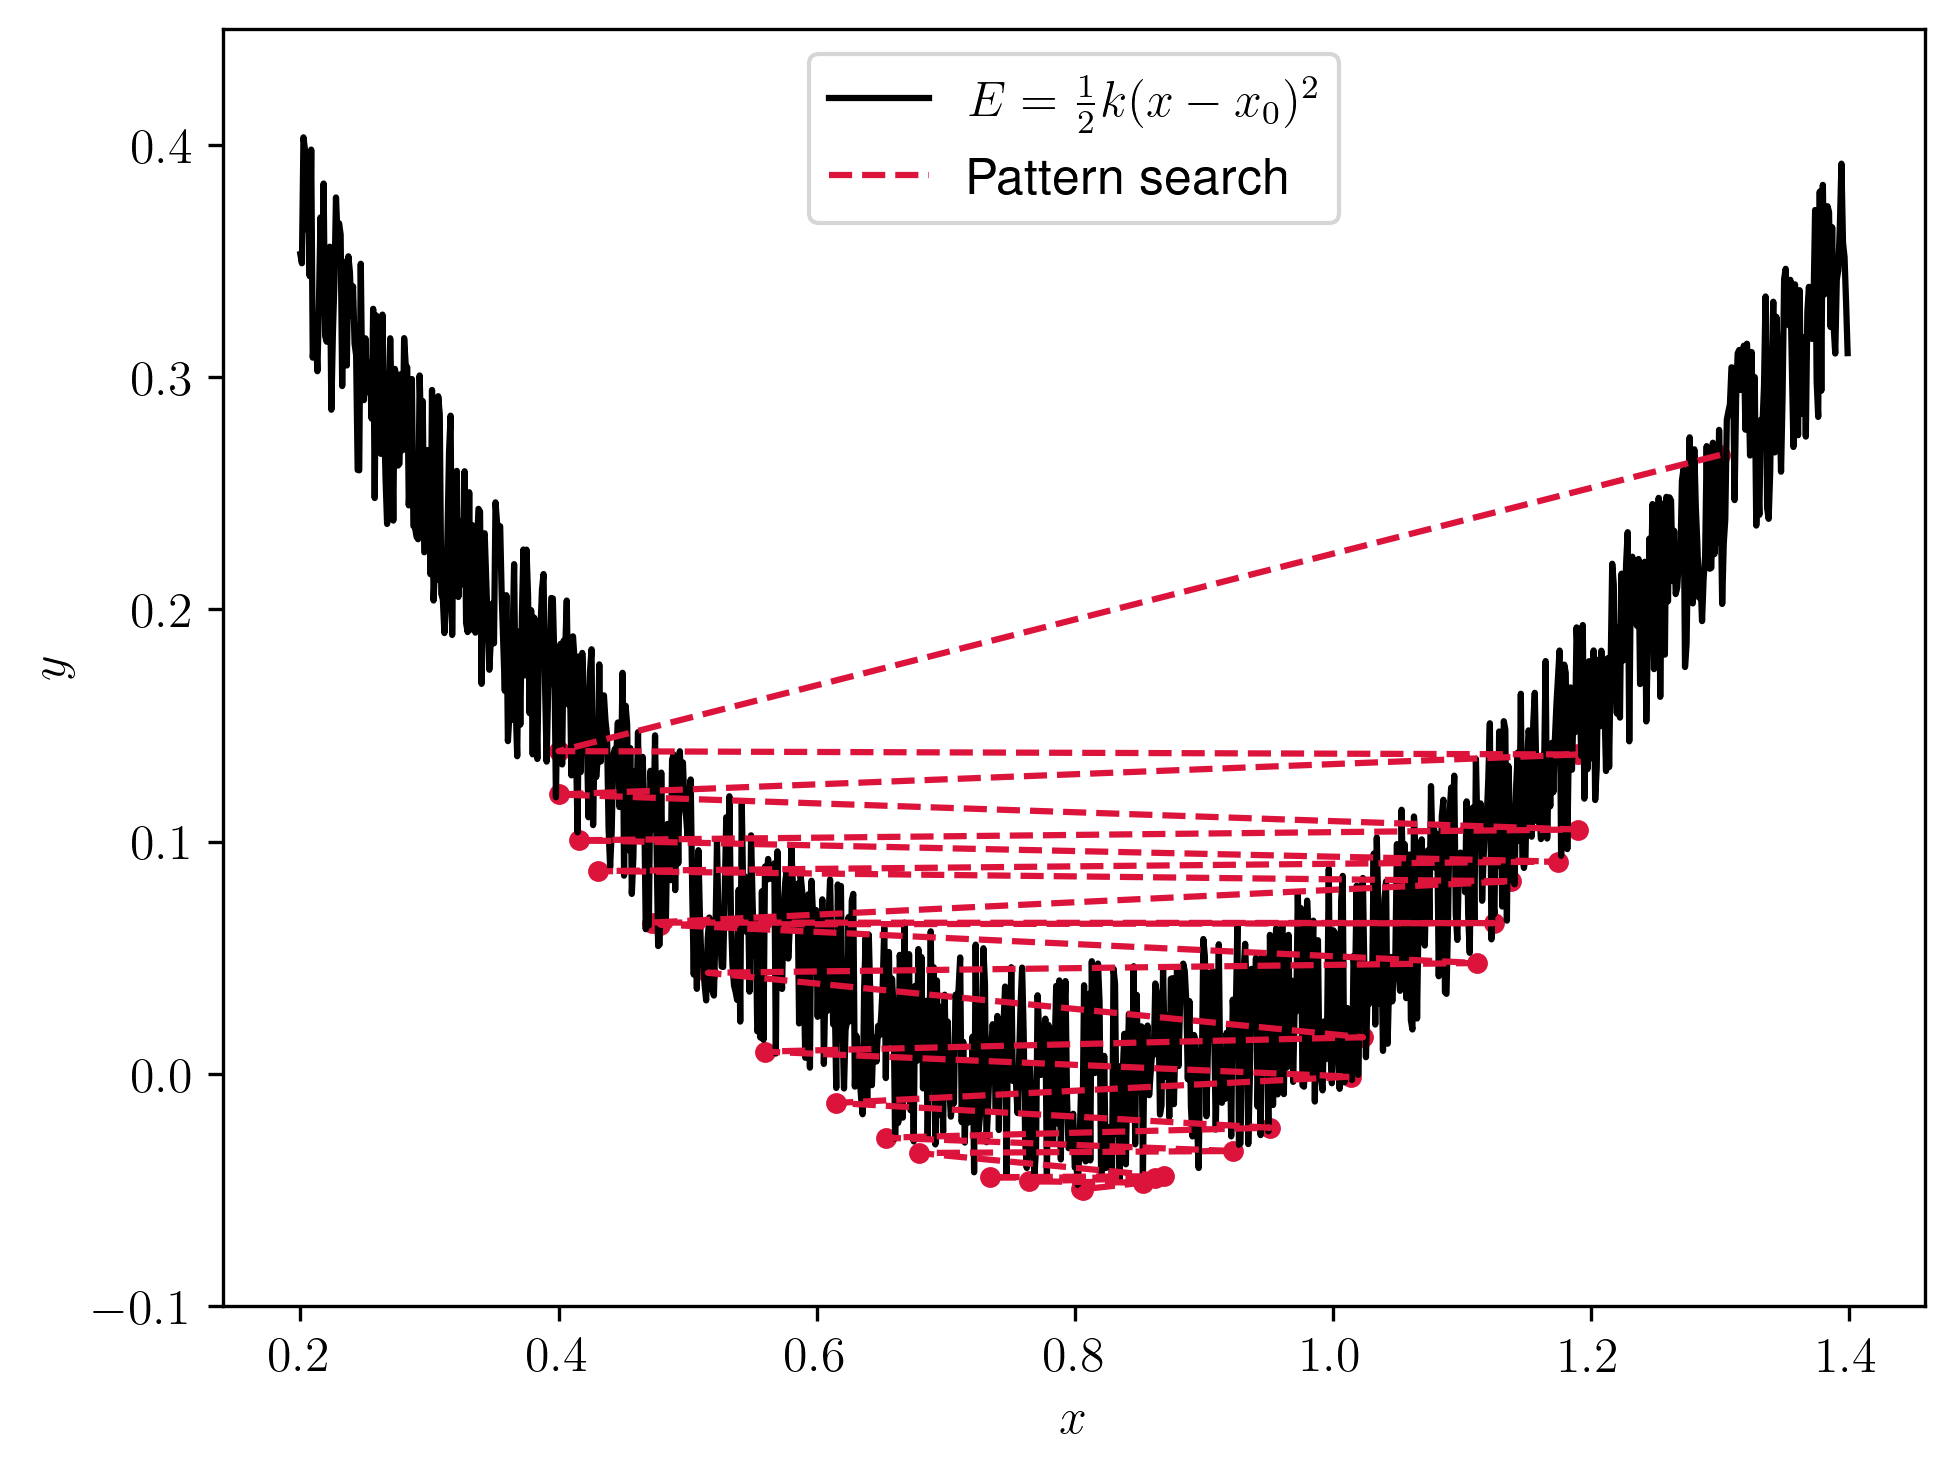

In [16]:
np.random.seed(seed)

opt = ps(
    parameters=parameters,
    bounds=bounds,
    maxiter=maxiter,
    random_samples=None,
    convergence_threashold=convergence_threashold,
    window_epochs=3,
    random_state=168548645,
    verbose=False,
)

y_best, x_best, history = opt.minimize(noisy_hook_law)
print(f"Minimum = {y_best:<10.5f} Iterations = {opt.iteration}")

x, y = history["x"], history["y"]
plot_1D(x, y, bounds, noisy_hook_law, label=r'$E=\frac{1}{2}k(x-x_0)^2$', label2='Pattern search')

### Questions

- GD clearly fails in optimizing the function. Why? Find a theoretical explanation and confirm it numerically.
- Can you compare GD and Adam? Which algorithm detail makes the difference?
- Vary the initial parameters for PS. Does this change the result?

## Exercise 3

Real world class optimization problems are multidimensional and feature multiple local minimum.

Consider the following function:

$$
\begin{equation}
y(x_0, x_1) =  x_0^2 + x_1^2 \\
               + 50 e^{\frac{-(x_0-2)^2}{2}} + 50 e^{\frac{-(x_1-2)^2}{2}} \\
               + 50 e^{\frac{-(x_0+2)^2}{2}} + 50 e^{\frac{-(x_1+2)^2}{2}} \\
               + 50 e^{\frac{-(x_0+2)^2}{2}} + 50 e^{\frac{-(x_1-2)^2}{2}} \\
               + 50 e^{\frac{-(x_0-2)^2}{2}} + 50 e^{\frac{-(x_1+2)^2}{2}}.
\end{equation}
$$

It features a global minimum at (0, 0), and multiple local minima.

In [25]:
def func_local_minimum_2(x):
    ''' 
    2D function with local minimum
    '''
    spike1 = 50 * np.exp(-((x[0]-2)**2 + (x[1]-2)**2)/2)
    spike2 = 50 * np.exp(-((x[0]+2)**2 + (x[1]+2)**2)/2)
    spike3 = 50 * np.exp(-((x[0]+2)**2 + (x[1]-2)**2)/2)
    spike4 = 50 * np.exp(-((x[0]-2)**2 + (x[1]+2)**2)/2)
    return x[0]**2 + x[1]**2 + spike1 + spike2 + spike3 + spike4


In [26]:
# Optimizers settings

bounds = (-5.5, 5.5)
parameters = [-1.5, -3]

maxiter = 10000
convergence_threashold=0.0001

learning_rate = 0.1
eps = 1e-8

beta = 0.99
beta1 = 0.9
beta2 = 0.999


Test different optimizers completing the code below.

Compare:
1. optimization efficiency
2. importance of choosing a proper starting point
3. exploration strategy of each optimizer
4. influence of each hyperparameter

Summarize results in a table and write a report showing how each optimizer behaves. 

### Pattern Search

2001


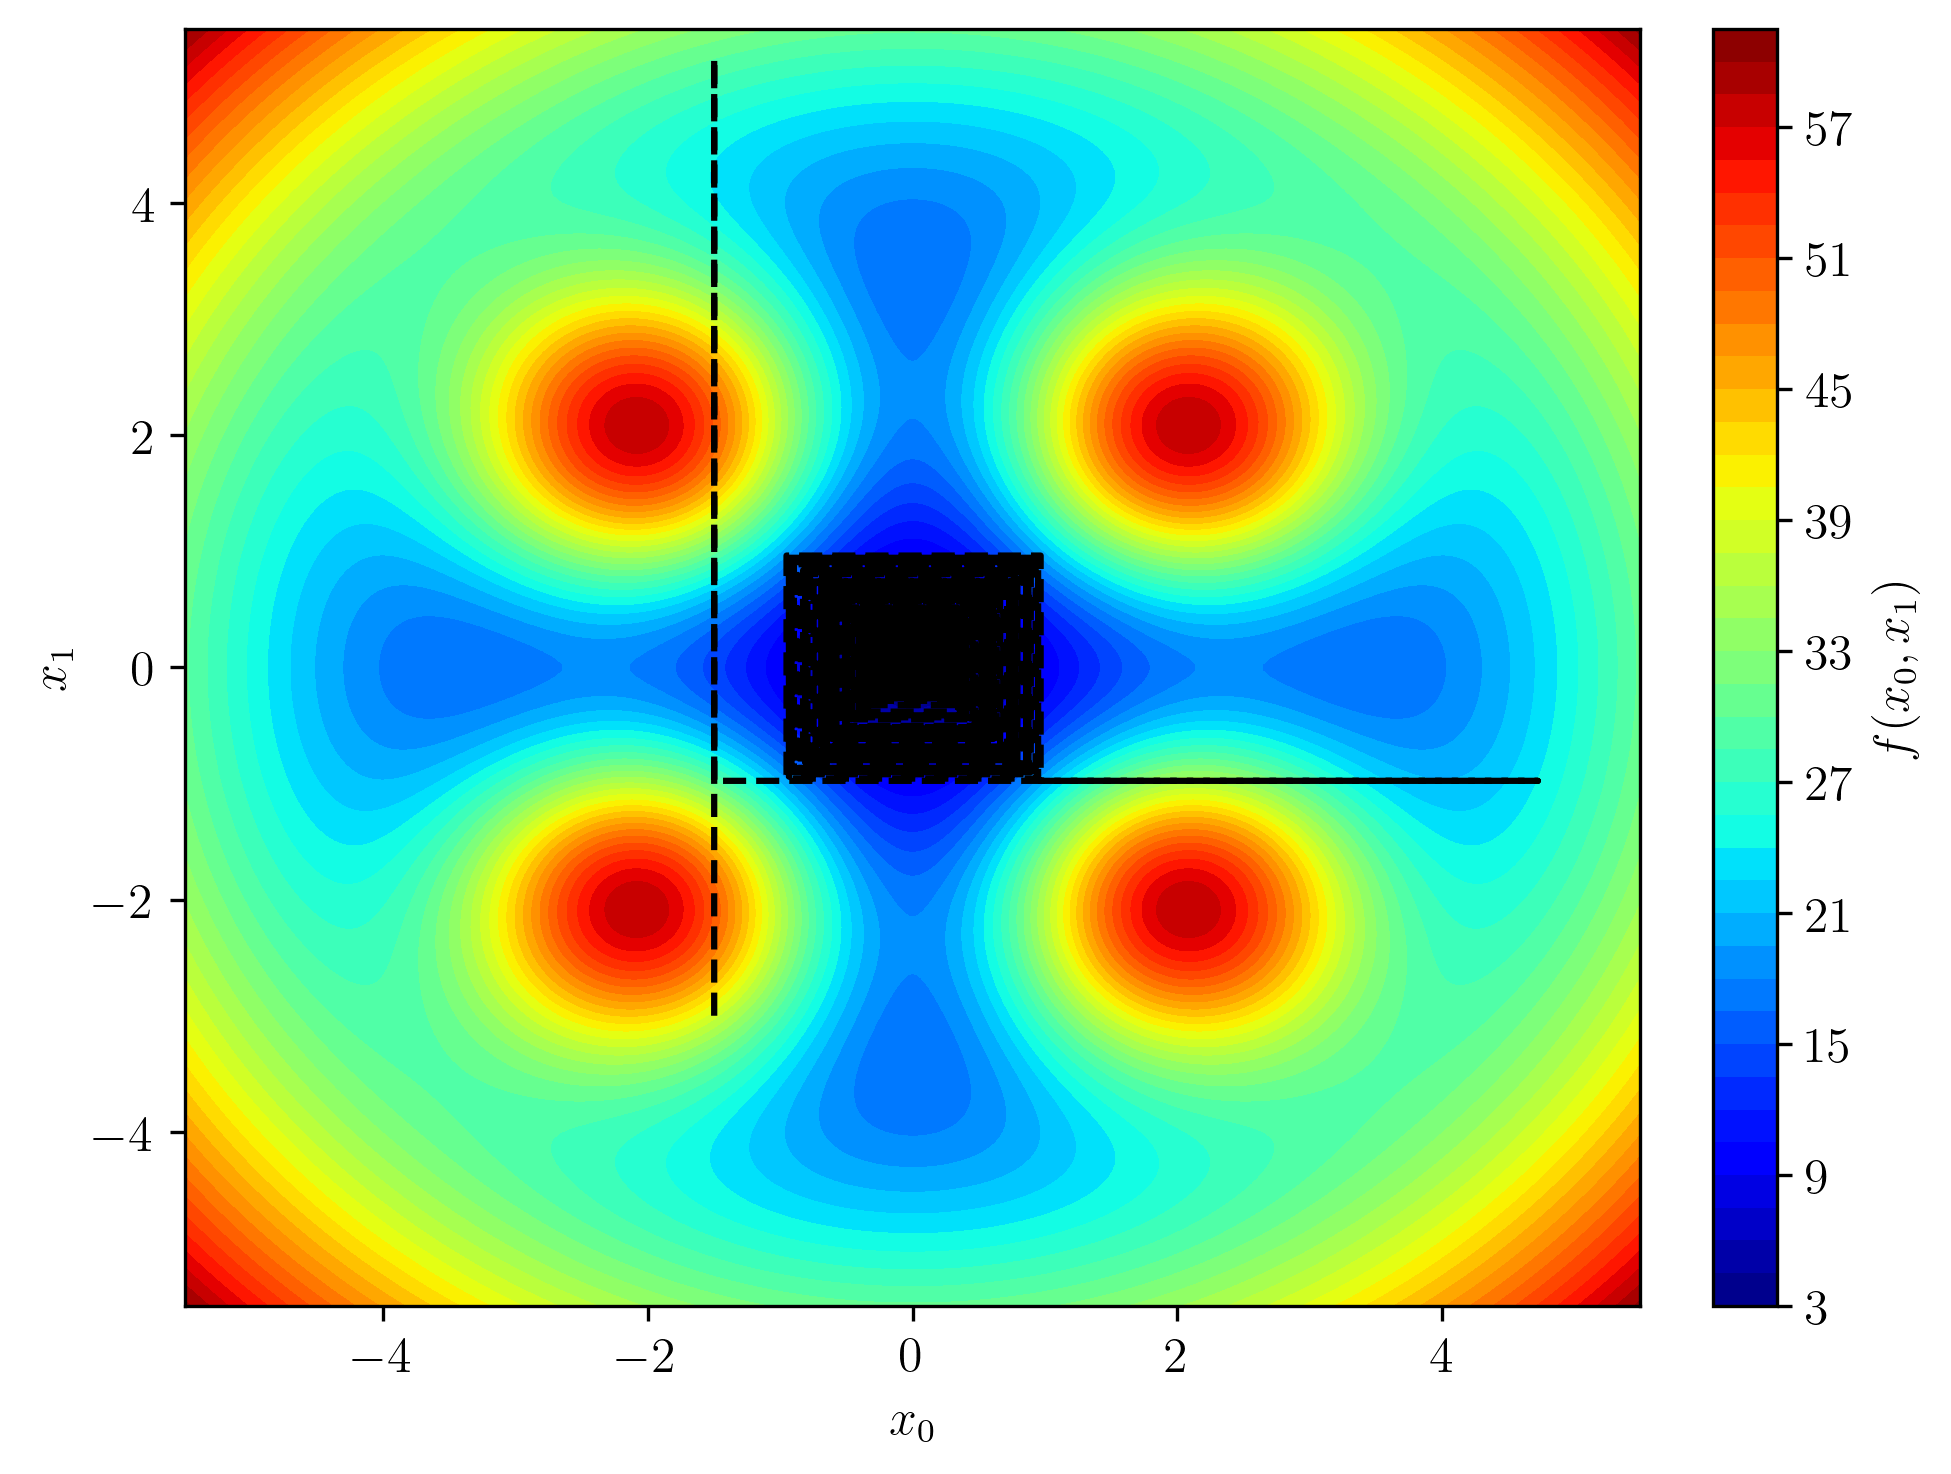

In [27]:
opt = ps(
    parameters=parameters,
    bounds=bounds,
    maxiter=maxiter,
    random_samples=None,
    convergence_threashold=convergence_threashold,
    window_epochs=3,
    random_state=168548645,
    verbose=False,
    # Adam's arguments
)

y_best, x_best, history = opt.minimize(func_local_minimum_2)
x, y = history["x"], history["y"]

print(opt.iteration)
plot_2D(x, bounds, func_local_minimum_2)

### Adam

2001


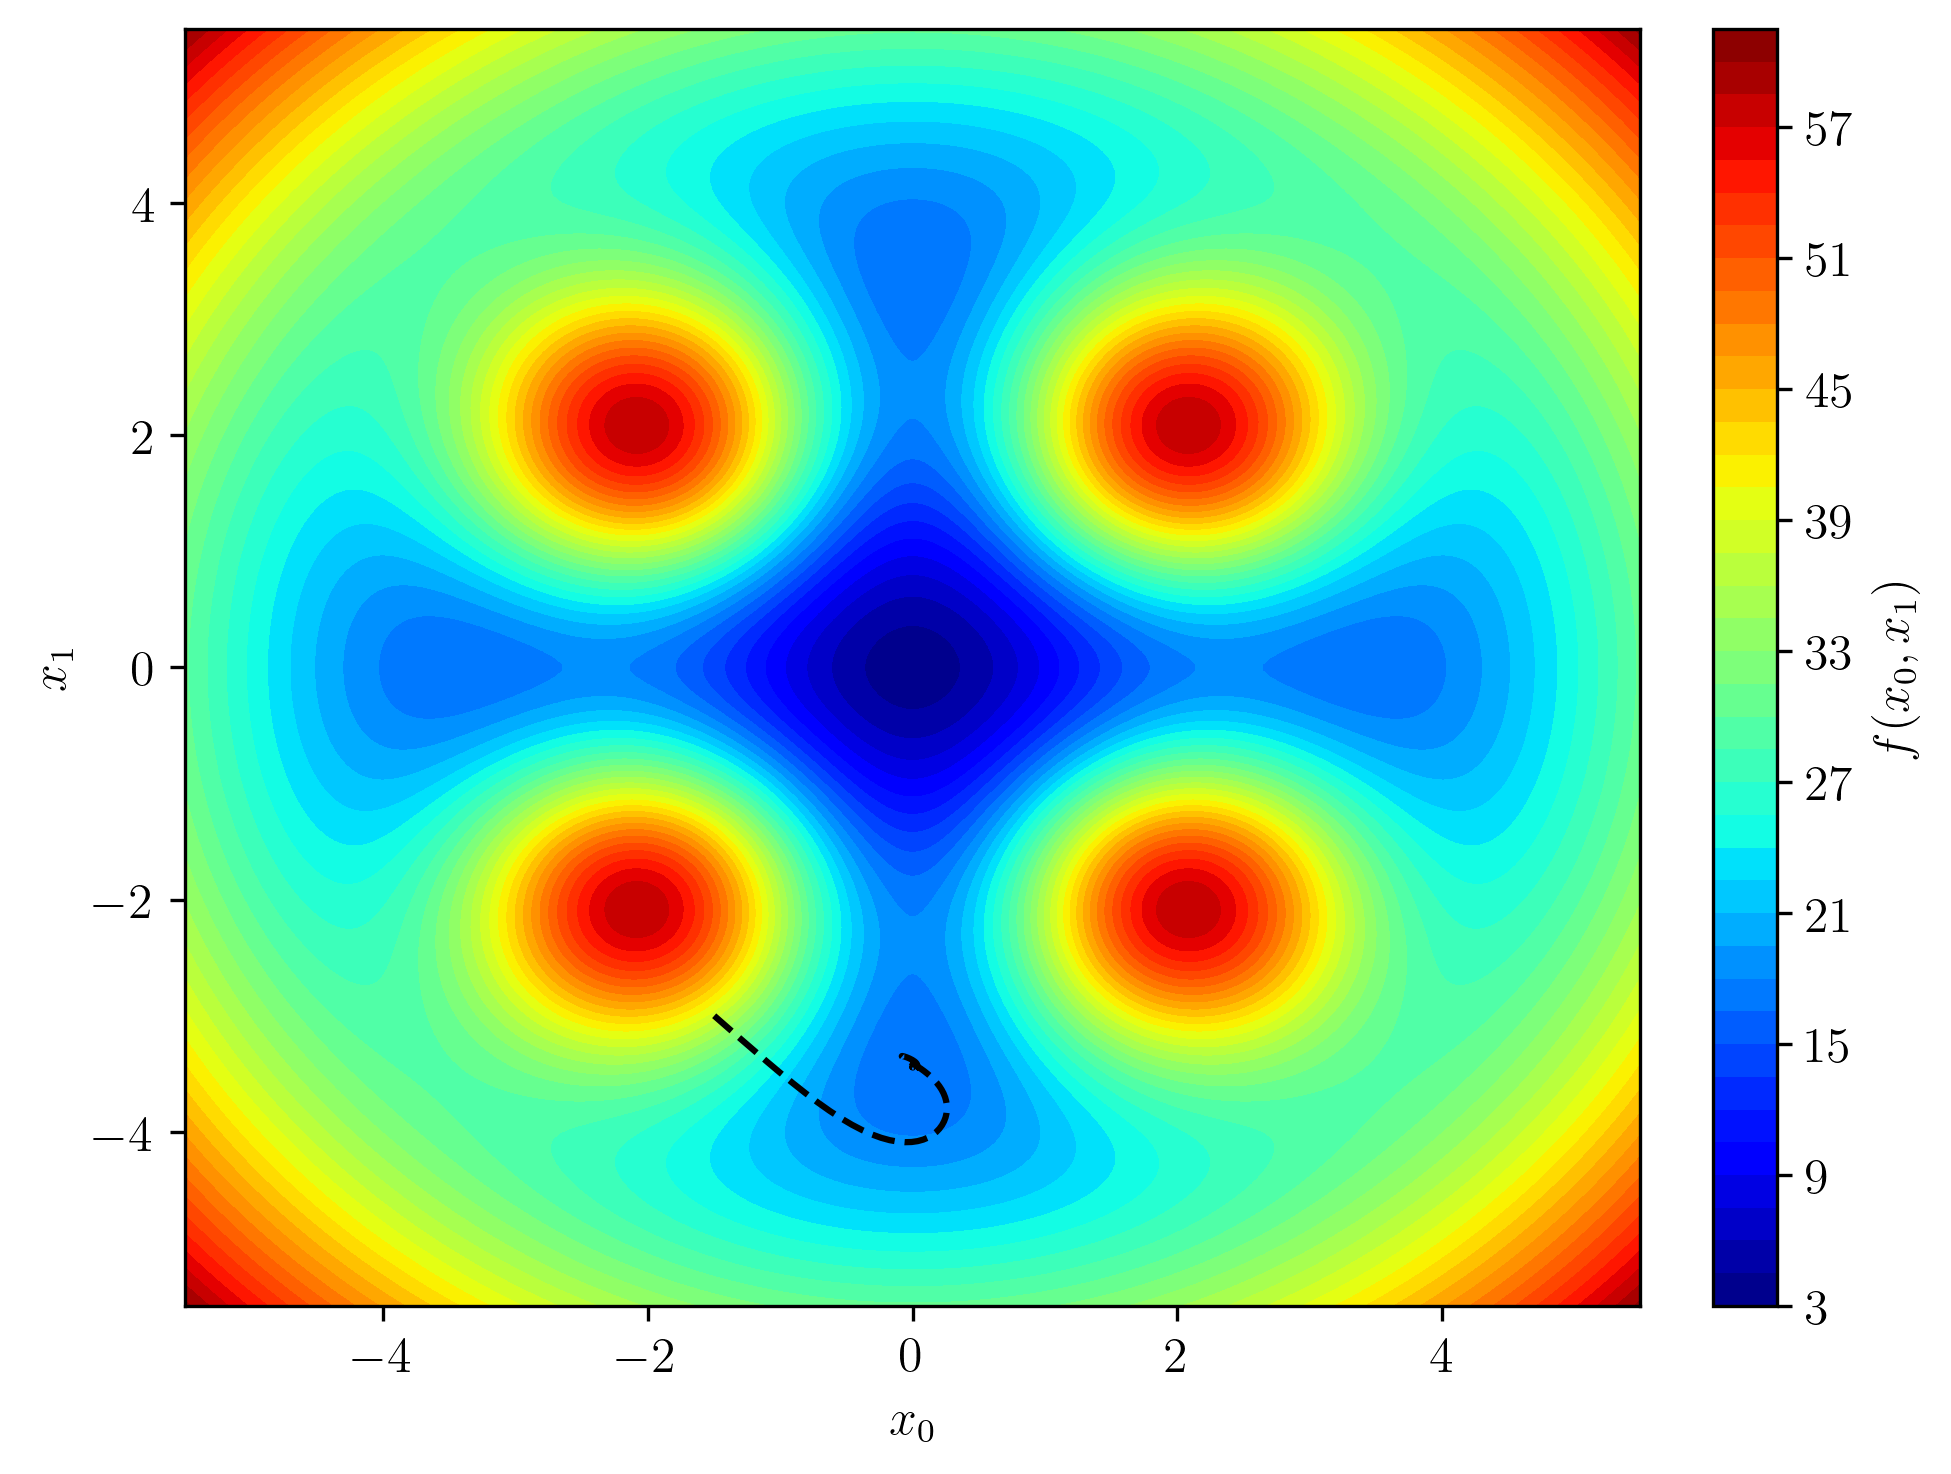

In [28]:
opt = adam(
    parameters=parameters,
    bounds=bounds,
    maxiter=maxiter,
    random_samples=None,
    convergence_threashold=convergence_threashold,
    window_epochs=3,
    random_state=168548645,
    verbose=False,
    # Adam's arguments
    learning_rate=learning_rate,
    beta1 = beta1,
    beta2 = beta2,
)

y_best, x_best, history = opt.minimize(func_local_minimum_2)
x, y = history["x"], history["y"]

print(opt.iteration)
plot_2D(x, bounds, func_local_minimum_2)

### Gradient Descent

2001


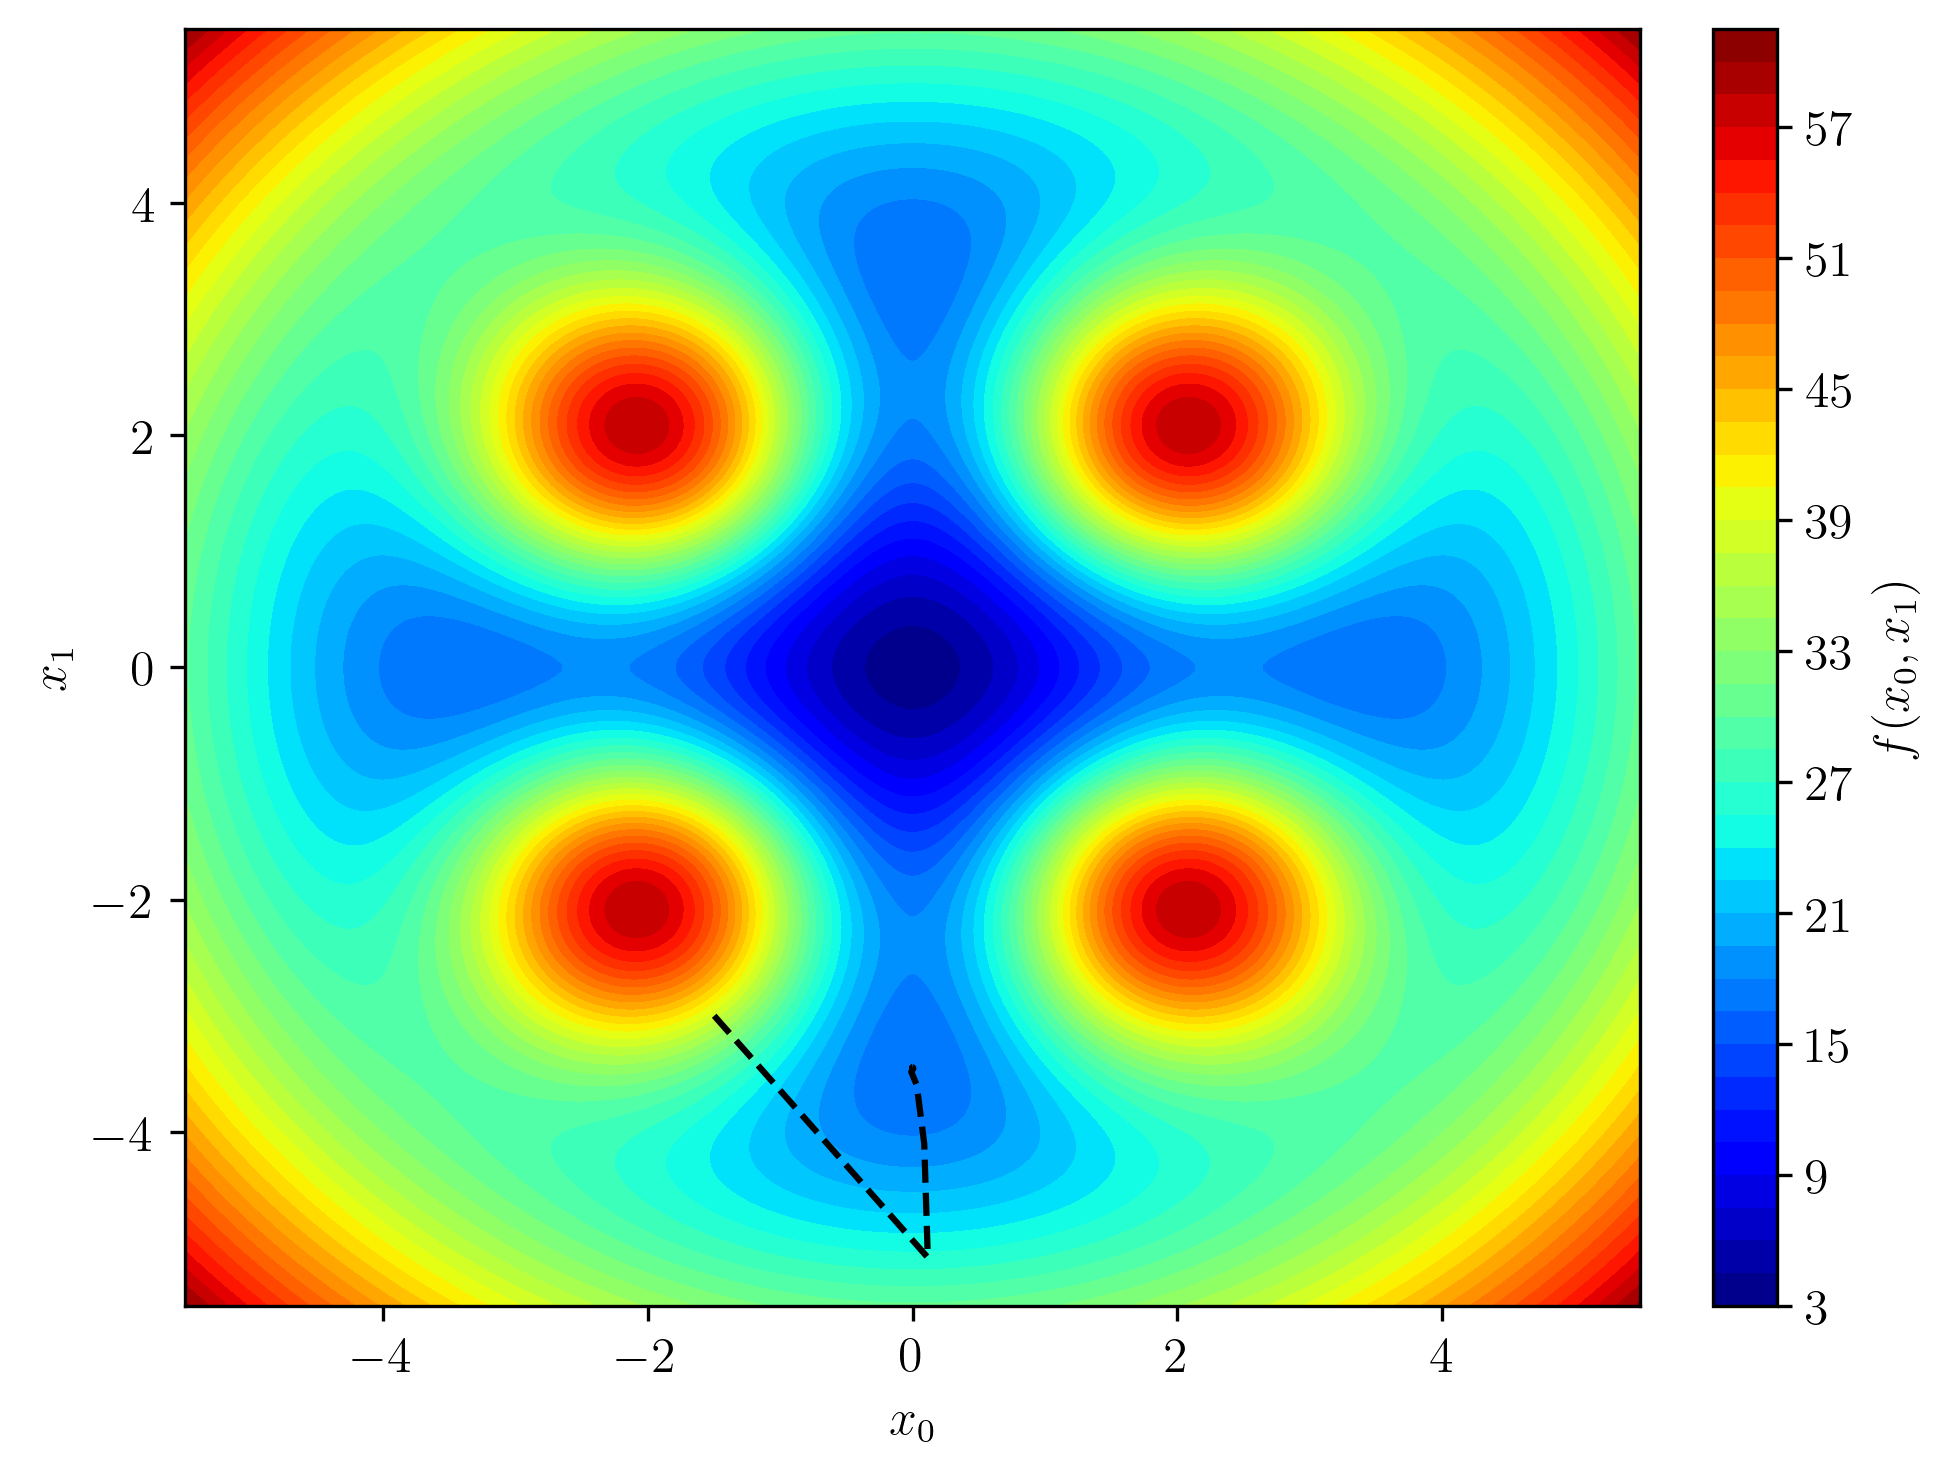

In [29]:
opt = gd(
    parameters=parameters,
    bounds=bounds,
    maxiter=maxiter,
    random_samples=None,
    convergence_threashold=convergence_threashold,
    window_epochs=3,
    random_state=168548645,
    verbose=False,
    # GD's arguments
    learning_rate=learning_rate,
)

y_best, x_best, history = opt.minimize(func_local_minimum_2)
x, y = history["x"], history["y"]

print(opt.iteration)
plot_2D(x, bounds, func_local_minimum_2)

### Questions

- The initialization of the algorithm is crucial. Try to find a way to reach the global minimum using a gradient-based algorithm.
- Does the random initialization implemented in OpenOptimizer enhance the convergence of the optimizer?
- Try to vary the learning rate of Adam. How does this affect the result?